In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append('../utils')
import database as db
if not os.path.exists("fig/rq2"):
    os.makedirs("fig/rq2")

connect to CVEFIXes


## Meta data of vulnerable packages

In [2]:
df_data = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
print("# vulnerablities:"+str(len(df_data)))
print("# vulnerable packages:"+str(len(set(df_data["package"]))))
vul_pack = df_data["package"].value_counts()
print("# average vulenrabilities in one packages:"+str(len(df_data)/len(set(df_data["package"]))))
print("# max vulenrabilities in one packages:"+str(vul_pack.max()))
print("# max vulenrabilities in one packages:"+str(vul_pack.min()))
print("# median vulenrabilities in one packages:"+str(vul_pack.median()))
print("std vulenrabilities in one packages:"+str(vul_pack.std()))

# vulnerablities:1050
# vulnerable packages:689
# average vulenrabilities in one packages:1.5239477503628447
# max vulenrabilities in one packages:26
# max vulenrabilities in one packages:1
# median vulenrabilities in one packages:1.0
std vulenrabilities in one packages:2.1253778262329623


## Affected Versions in vulnerable packages

In [3]:
import os
from packaging import version
from packaging.version import parse as parseVersion
from itertools import chain

def get_num_affected_version(versions, package):
    num = 0
    total_versions = list()
    visited = list()
    cur = db.conn.cursor()
    cur.execute(f"SELECT num from versions where\
                crate_id = (SELECT id from crates where name=\'{package}\')")
    results = cur.fetchall()
    for res in results:
        try:
            parseVersion(res[0])
        except:
            continue
        total_versions.append(res[0])
        visited.append(False)
        total_versions.sort(key=parseVersion)

    found = False
    for v in versions:
        introduced = v[0]
        fixed = v[1]
        try:
            if not introduced or not fixed:
                continue
            version.parse(introduced)
            version.parse(fixed)
        except version.InvalidVersion as iv:
            print(f"Invalid version: {iv}")
            continue
        except Exception as e:
            print(f"Exception: {e}")
            continue
        # count the affected versions
        for i in range(len(total_versions)):
            if not found and introduced!="":
                if version.parse(introduced)<=version.parse(total_versions[i]):
                    found = True
                    visited[i] = True
            if found:
                if fixed!="None" and fixed:
                    if version.parse(fixed)>version.parse(total_versions[i]):
                        visited[i] = True
                else:
                    visited[i] = True
        if fixed!="None" and fixed and len(total_versions) > 0 and version.parse(fixed)>version.parse(total_versions[-1]):
            visited.append(False)
#     print(len(visited), sum(visited))
    return [len(visited), sum(visited)]

def calc_ver(x):
    return ",".join(x)

df_data = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
df_version = df_data.groupby('package')['vul_version'].apply(calc_ver)
df_version = df_version.apply(lambda x: list(chain.from_iterable(eval("["+x+"]"))))
df_version = pd.DataFrame(df_version).reset_index(level=0)
temp = df_version.apply(lambda x: get_num_affected_version(x['vul_version'], x['package']), axis=1)
df_version["affected_perc"] = temp.apply(lambda x: x[1]/x[0] if x[0]!=0 else 0)
df_version["affected"] = temp.apply(lambda x: x[0])
df_version = df_version[df_version["affected"]!=0]
print("# average affected version in package:"+str(df_version["affected"].sum()/len(df_version["affected"])))
print("# max affected version in package:"+str(df_version["affected"].max()))
print("# min affected version in package:"+str(df_version["affected"].min()))
print("# median affected version in package:"+str(df_version["affected"].median()))
print("std affected version in package:"+str(df_version["affected"].std()))
print("===================")
print("# average percentage of affected version in package:"+str(df_version["affected_perc"].sum()/len(df_version["affected"])))
print("# max percentage of affected version in package:"+str(df_version["affected_perc"].max()))
print("# min percentage of affected version in package:"+str(df_version["affected_perc"].min()))
print("# median percentage of affected version in package:"+str(df_version["affected_perc"].median()))
print("std percentage of affected version in package:"+str(df_version["affected_perc"].std()))

Invalid version: Invalid version: '1.5.8-0.20250204093451-1f4db20199b8'
Invalid version: Invalid version: '2.0.6-0.20250204103256-d62c3b826a9d'
Invalid version: Invalid version: '0.0.0-20250204093451-1f4db20199b8'
Invalid version: Invalid version: '2.0.0-20250204103256-d62c3b826a9d'
Invalid version: Invalid version: '0.0.0-20250406010349-76805d5a8860'
Invalid version: Invalid version: '1.1.2-0.20250406010349-76805d5a8860'
Invalid version: Invalid version: '5.0.4-0.20231016150651-428517fef5b9'
Invalid version: Invalid version: '0.0.0-20231016150651-428517fef5b9'
Invalid version: Invalid version: '6.1.1-0.20231016150651-428517fef5b9'
Invalid version: Invalid version: '0.0.0-20231218163308-9d2ee975ef9f'
# average affected version in package:39.637982195845694
# max affected version in package:438
# min affected version in package:1
# median affected version in package:23.0
std affected version in package:48.07386076280523
# average percentage of affected version in package:0.4816733540340

### Rust packages with most vulnerabilities

In [4]:
df_data = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
temp = df_data["package"].value_counts()
temp = temp[temp.values>3]
print(temp)
print(df_version[df_version['package'].apply(lambda x: True if x in list(temp.index) else False)].drop(["vul_version"], axis=1))

package
openssl-src                     26
surrealdb                       26
deno                            23
wasmtime                        22
ckb                             19
apollo-router                   12
openssl                         10
tough                            8
rustfs                           8
hyper                            7
cargo                            6
tauri                            6
Simple-Wayland-HotKey-Daemon     6
comrak                           5
smallvec                         5
matrix-sdk-crypto                5
bottlerocket/update-operator     5
tokio                            5
sudo-rs                          5
pleaser                          4
ntpd                             4
slice-deque                      4
ammonia                          4
pyo3                             4
quiche                           4
routinator                       4
gix-path                         4
evm                              4
russh       

### Packages with all versions affected by vulnerabilities

In [5]:
temp = df_version[df_version['affected_perc']==1]
packs = list(temp['package'])
df_pack = pd.read_sql("SELECT id, name, downloads FROM crates", con=db.conn)
df_pack['downloads'] = df_pack['downloads'].apply(lambda x: float(x))
all_affected_pack = df_pack[df_pack["name"].apply(lambda x: x in packs)]
print(f"# of packages with all versions affected by vuls: {len(set(packs))}")
print(all_affected_pack[all_affected_pack['downloads']<100000])
# print(df_pack[df_pack['downloads']>1000000])

DatabaseError: Execution failed on sql 'SELECT id, name, downloads FROM crates': no such column: downloads

## Type of Vulnerabilities by Crate Category

In [ ]:
# Input: vulnerable package
# Output: category downloads, category crates_cnt, vulnerabilities in category
from collections import Counter
from statistics import median

categories = dict()
keywords = dict()
numCategory = list()
df_data = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
df_pack = df_data.drop_duplicates(subset="package", keep='first')

for index, row in df_data.iterrows():
    package = row["package"]
    cur = db.conn.cursor()
    cur.execute("SELECT category from categories where id in (\
                SELECT category_id from crates_categories where\
                crate_id = (SELECT id from crates where name=\'"+package+"\'))")
    results = cur.fetchall()
#     if len(results)==0:
#         categories["no categories"] += 1
    numCategory.append(len(results))
    visited = set()
    for res in results:
        res = res[0]
        words = res.split("::")
        if words[0] not in visited:
            if categories.get(words[0]) == None:
                categories[words[0]] = 1
                visited.add(words[0])
            else:
                categories[words[0]] += 1
                visited.add(words[0])
categories = dict(sorted(categories.items(), key=lambda d:d[1], reverse = True))

print(Counter(numCategory))
print("# average categories: " +str(sum(numCategory)/len(df_pack)))
print("# average categories excluding non-category crates: " +str(sum(numCategory)/(len(df_data)-Counter(numCategory)[0])))
print("# median categories: " +str(median(numCategory)))
print("# median categories excluding non-category crates: " +str(median(list(filter(lambda a: a != 0, numCategory)))))
for k, v in categories.items():
    print(k, v)
print("# total repeatitive vulnerabities: "+str(sum(categories.values())))
target_cat = categories.keys()
# for key, value in categories.items():
#     cur = conn.cursor()
#     cur.execute("SELECT crates_cnt from categories where category=\'"+key+"\'")
# x_axis = list(categories.keys())
# y_axis = list(categories.values())
    

Counter({0: 534, 2: 194, 1: 156, 3: 122, 4: 48, 5: 21})
# average categories: 1.6904761904761905
# average categories excluding non-category crates: 2.2310536044362292
# median categories: 1
# median categories excluding non-category crates: 2
No standard library 113
Network programming 101
Data structures 96
Cryptography 91
Web programming 69
Asynchronous 63
API bindings 47
Memory management 41
Command line utilities 41
Encoding 40
Embedded development 40
Development tools 39
Algorithms 39
Concurrency 32
Parser implementations 26
Database implementations 26
Rust patterns 23
Parsing tools 22
Text processing 21
WebAssembly 19
Operating systems 18
Filesystem 17
GUI 15
Database interfaces 13
Command-line interface 12
Multimedia 11
External FFI bindings 10
Caching 9
Compression 8
Email 7
Value formatting 6
Authentication 6
Compilers 5
Date and time 5
Science 5
Virtualization 4
Rendering 4
Hardware support 4
Mathematics 4
Graphics 3
Game development 2
Game engines 2
Internationalization (i1

## Distribution of vulnerability types across package categories

In [ ]:
def get_sfp_across_pack(df):
    res = list()
    temp = df["sfp_id"].apply(lambda x: list() if x.strip('][').replace('\'', '')=='' else x.strip('][').replace('\'', '').split(', '))
    temp = temp.apply(lambda x: len(x))
    temp = temp[temp.apply(lambda x: False if x==0 else True)]
    total = temp.sum()
  
    cve_type = {'Memory Access':0, 'Memory Management':0, 'Synchronization':0, 'Tainted Input':0,\
                'Resource Management':0, 'Exception Management':0, 'Cryptography':0, 'Other':0,\
               'Risky Values':0, 'Path Resolution':0, 'Information Leak':0, 'Privilege':0, \
               'Predictability':0, 'Authentication':0, 'API':0, 'Access Control':0, 'Failure to Release Memory':0}
    cve_type["non category"] = 0
    for index, row in df.iterrows():
        categories = eval(row["sfp_id"])
        if categories!= None and len(categories):
            for cat in categories:
                if cve_type.get(cat) == None:
                    cve_type[cat] = 1
                else:
                    cve_type[cat] += 1
        else:
            cve_type["non category"]+=1
#     cve_type = sorted(cve_type.items(), key=lambda kv: kv[1])
#     print(type(cve_type))
    for k, v in cve_type.items():
        # print(k+" "+str(v)+" "+str(v/total))
        res.append(v)
    return res
        
df_data = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
categories = list()
# cnt = 0
for index, row in df_data.iterrows():
    package = row["package"]
    cur = db.conn.cursor()
    cur.execute("SELECT category from categories where id in (\
                SELECT category_id from crates_categories where\
                crate_id = (SELECT id from crates where name=\'"+package+"\'))")
    results = cur.fetchall()
    cat = set()
    for res in results:
        res = res[0]
        words = res.split("::")
#         if "Web programming" in words[0]:
#             cnt += 1
        cat.add(words[0])
    categories.append(list(cat))
# print(cnt)
df_data['category'] = categories

df_wilcoxon = pd.DataFrame()
interest_cat = ["Memory management", "Concurrency", "Data structures", "Caching", "No standard library", "Network programming"]
for cat in interest_cat:
    # print("vulnerablility types across "+cat)
    df_mem = df_data[df_data['category'].apply(lambda x: True if cat in x else False)]
    # print(len(df_mem))
#     print(df_mem['category'])
    df_wilcoxon[cat] = get_sfp_across_pack(df_mem)
   
df_wilcoxon

,Memory management,Concurrency,Data structures,Caching,No standard library,Network programming
0,18,8,23,4,33,14
1,23,20,42,6,45,18
2,11,20,12,4,10,5
3,2,4,7,0,7,13
4,2,3,15,1,21,34
5,2,1,13,0,7,4
6,0,0,0,0,15,8
7,1,0,5,0,7,5
8,3,0,5,0,6,2
9,1,0,2,0,0,7


In [ ]:
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

categories = ['Memory management', 'Concurrency', 'Data structures', 'Caching', 'Network programming', 'No standard library']
pvals = []
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        print(categories[i], categories[j])
        print(sp.posthoc_wilcoxon([list(df_wilcoxon[categories[i]]), list(df_wilcoxon[categories[j]])], p_adjust='bonferroni'))
        wilcoxon = stats.wilcoxon(df_wilcoxon[categories[i]], df_wilcoxon[categories[j]])
        pvals.append(wilcoxon.pvalue)
print(multipletests(pvals, method='bonferroni'))

Memory management Concurrency
          1         2
1  1.000000  0.326193
2  0.326193  1.000000
Memory management Data structures
         1        2
1  1.00000  0.00402
2  0.00402  1.00000
Memory management Caching
          1         2
1  1.000000  0.003176
2  0.003176  1.000000
Memory management Network programming
          1         2
1  1.000000  0.095623
2  0.095623  1.000000
Memory management No standard library
          1         2
1  1.000000  0.002295
2  0.002295  1.000000
Concurrency Data structures
          1         2
1  1.000000  0.016263
2  0.016263  1.000000
Concurrency Caching
          1         2
1  1.000000  0.017148
2  0.017148  1.000000
Concurrency Network programming
          1         2
1  1.000000  0.023686
2  0.023686  1.000000
Concurrency No standard library
          1         2
1  1.000000  0.008734
2  0.008734  1.000000
Data structures Caching
         1        2
1  1.00000  0.00333
2  0.00333  1.00000
Data structures Network programming
          1   

## Vulnearability Locality

In [ ]:
df_data = pd.read_sql("SELECT * FROM ext_commits", con=db.conn)
files = df_data['num_files'].apply(lambda x: float(x))
print("# average files: " + str(files.sum()/len(files)))
print("# median files: " + str(files.median()))
print("# minimum files: " + str(files.min()))
print("# maximum files: " + str(files.max()))
print("# toatl files: " + str(files.sum()))
print("std of files: " + str(files.std()))

df_data = pd.read_sql("SELECT * FROM vul_safe_unsafe", con=db.conn)
df_data["unsafe_trait"] = float('nan')
# df_manual = pd.read_sql("SELECT * FROM vul_safe_unsafe_manual2", con=db.conn)
# df = df.append(df_manual, ignore_index=True)
df_data['safe_func'] = df_data['safe_func'].apply(lambda x: float(x))
df_data['unsafe_func'] = df_data['unsafe_func'].apply(lambda x: float(x))
df_data['unsafe_block'] = df_data['unsafe_block'].apply(lambda x: float(x))
print("====================================")
print("# average safe_function: " + str(df_data['safe_func'].sum()/len(df_data)))
print("# median safe_function: " + str(df_data['safe_func'].median()))
print("# minimum safe_function: " + str(df_data['safe_func'].min()))
print("# maximum safe_function: " + str(df_data['safe_func'].max()))

print("# toatl safe_function: " + str(df_data['safe_func'].sum()))
print("std of safe_function: " + str(df_data['safe_func'].std()))

print("====================================")
print("# average unsafe_function: " + str(df_data['unsafe_func'].sum()/len(df_data)))
print("# median unsafe_function: " + str(df_data['unsafe_func'].median()))
print("# minimum unsafe_function: " + str(df_data['unsafe_func'].min()))
print("# maximum unsafe_function: " + str(df_data['unsafe_func'].max()))
print("# toatl unsafe_function: " + str(df_data['unsafe_func'].sum()))
print("std of unsafe_function: " + str(df_data['unsafe_func'].std()))

print("====================================")
print("# average unsafe_block: " + str(df_data['unsafe_block'].sum()/len(df_data)))
print("# median unsafe_block: " + str(df_data['unsafe_block'].median()))
print("# minimum unsafe_block: " + str(df_data['unsafe_block'].min()))
print("# maximum unsafe_block: " + str(df_data['unsafe_block'].max()))
print("# toatl unsafe_block: " + str(df_data['unsafe_block'].sum()))
print("std of unsafe_block: " + str(df_data['unsafe_block'].std()))


# average files: 4.084648493543759
# median files: 2.0
# minimum files: 1.0
# maximum files: 363.0
# toatl files: 2847.0
std of files: 15.177304864769708
# average safe_function: 19.44744744744745
# median safe_function: 4.0
# minimum safe_function: 0.0
# maximum safe_function: 2370.0
# toatl safe_function: 6476.0
std of safe_function: 132.09993399406355
# average unsafe_function: 0.5735735735735735
# median unsafe_function: 0.0
# minimum unsafe_function: 0.0
# maximum unsafe_function: 52.0
# toatl unsafe_function: 191.0
std of unsafe_function: 4.141127635647231
# average unsafe_block: 3.2912912912912913
# median unsafe_block: 0.0
# minimum unsafe_block: 0.0
# maximum unsafe_block: 182.0
# toatl unsafe_block: 1096.0
std of unsafe_block: 15.870973044389473


### vulnerability locality across vulnerability types.

In [6]:
df_vul = pd.read_sql("SELECT id, package, sfp_id, published, severity FROM cve", con=db.conn)
df_data = pd.read_sql("SELECT * FROM vul_safe_unsafe", con=db.conn)
df_data["unsafe_trait"] = 0
# df_manual = pd.read_sql("SELECT * FROM vul_safe_unsafe_manual2", con=db.conn)
# df_data = df.append(df_manual, ignore_index=True)

df_files = pd.read_sql("SELECT cve_id, hash, num_files FROM ext_commits", con=db.conn)
df_data['safe_function'] = df_data['safe_func'].apply(lambda x: float(x))
df_data['unsafe_function'] = df_data['unsafe_func'].apply(lambda x: float(x))
df_data['unsafe_block'] = df_data['unsafe_block'].apply(lambda x: float(x))
df_data['unsafe_trait'] = df_data['unsafe_trait'].apply(lambda x: float(x))
def get_cat(x, cat):
    temp = eval(df_vul[df_vul['id']==x]['sfp_id'].values[0]) if len(df_vul[df_vul['id']==x]['sfp_id'].values)>0 else []
    if cat in temp:
        return True
    return False
cats = ['Memory Access', 'Memory Management', 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Path Resolution']
for cat in cats:
    df = df_data[df_data["cve_id"].apply(lambda x: get_cat(x, cat))]
    
    def print_statistics(col):
        print(f"# average {col}: " + str(df[col].sum()/len(df)))
        print(f"# median {col}: " + str(df[col].median()))
        print(f"# minimum {col}: " + str(df[col].min()))
        print(f"# maximum {col}: " + str(df[col].max()))
        print(f"# toatl {col}: " + str(df[col].sum()))
        print(f"std of {col}: " + str(df[col].std()))
        print("==================================")
    print("Commit Locality Across "+cat)
    print_statistics('safe_function')
    print_statistics('unsafe_function')
    print_statistics('unsafe_block')
    print_statistics('unsafe_trait')
    num_unsafe = len(df[df.apply(lambda x: x.unsafe_block > 0 or x.unsafe_function >0 or x.unsafe_trait>0, axis=1)])
    print(f"# vulnerabilities involve unsafe: {num_unsafe}")
    print(len(df))
    print("\n")
for cat in cats:
    df = df_files[df_files["cve_id"].apply(lambda x: get_cat(x, cat))]
    df['num_files'] = df['num_files'].apply(lambda x: int(x))
    print("Vulnerability Locality Across "+cat)
    print("# minimum files: " + str(df['num_files'].min()))
    print("# maximum files: " + str(df['num_files'].max()))
    print("# median files: " + str(df['num_files'].median()))
    print("# average files: " + str(df['num_files'].sum()/len(df)))
    print("# toatl files: " + str(df['num_files'].sum()))
    print("std of files: " + str(df['num_files'].std()))

Commit Locality Across Memory Access
# average safe_function: 7.057971014492754
# median safe_function: 2.0
# minimum safe_function: 0.0
# maximum safe_function: 204.0
# toatl safe_function: 487.0
std of safe_function: 24.56497031162285
# average unsafe_function: 1.0434782608695652
# median unsafe_function: 0.0
# minimum unsafe_function: 0.0
# maximum unsafe_function: 52.0
# toatl unsafe_function: 72.0
std of unsafe_function: 6.29059705061427
# average unsafe_block: 2.3768115942028984
# median unsafe_block: 0.0
# minimum unsafe_block: 0.0
# maximum unsafe_block: 70.0
# toatl unsafe_block: 164.0
std of unsafe_block: 8.499310437903981
# average unsafe_trait: 0.0
# median unsafe_trait: 0.0
# minimum unsafe_trait: 0.0
# maximum unsafe_trait: 0.0
# toatl unsafe_trait: 0.0
std of unsafe_trait: 0.0
# vulnerabilities involve unsafe: 39
69


Commit Locality Across Memory Management
# average safe_function: 16.0
# median safe_function: 4.0
# minimum safe_function: 0.0
# maximum safe_function: 20

/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))


Vulnerability Locality Across Memory Access
# minimum files: 1
# maximum files: 14
# median files: 1.0
# average files: 1.8376068376068375
# toatl files: 215
std of files: 1.9026173667058688


/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))


Vulnerability Locality Across Memory Management
# minimum files: 1
# maximum files: 56
# median files: 1.0
# average files: 2.782258064516129
# toatl files: 345
std of files: 6.4626009562600375


/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))


Vulnerability Locality Across Synchronization
# minimum files: 1
# maximum files: 60
# median files: 1.0
# average files: 4.035714285714286
# toatl files: 226
std of files: 9.810873903646238
Vulnerability Locality Across Tainted Input
# minimum files: 1
# maximum files: 22
# median files: 2.0
# average files: 2.9245283018867925
# toatl files: 310
std of files: 3.449494409350993


/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))
/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))


Vulnerability Locality Across Resource Management
# minimum files: 1
# maximum files: 17
# median files: 2.0
# average files: 2.679738562091503
# toatl files: 410
std of files: 2.7136438766159583


/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))


Vulnerability Locality Across Exception Management
# minimum files: 1
# maximum files: 56
# median files: 1.0
# average files: 3.6382978723404253
# toatl files: 171
std of files: 8.302502325556132
Vulnerability Locality Across Path Resolution
# minimum files: 1
# maximum files: 8
# median files: 1.0
# average files: 1.6875
# toatl files: 54
std of files: 1.4013242584852925


/tmp/ipykernel_89210/1164233139.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))


### Unsafe normalization

In [ ]:
from scipy.stats import wilcoxon
import seaborn as sns
df_vul = pd.read_sql("SELECT * FROM vul_safe_unsafe", con=db.conn)
df_vul["unsafe_trait"] = float('nan')
# df_manual = pd.read_sql("SELECT * FROM vul_safe_unsafe_manual2", con=db.conn)
# df_vul = df.append(df_manual, ignore_index=True)

df_total = pd.read_sql("SELECT * FROM total_safe_unsafe", con=db.conn)
df_regex = pd.read_sql("SELECT * FROM total_safe_unsafe_regex", con=db.conn)
df_total = pd.concat([df_total, df_regex], ignore_index=True)

def get_unsafe_safe_perc(df, version):
    total_safe_func = df['safe_func'].astype(float).sum()
    total_unsafe_func = df['unsafe_func'].astype(float).sum()
    total_unsafe_block = df['unsafe_block'].astype(float).sum()
    df["unsafe_func_perc"] = df.apply(lambda x: float(x.unsafe_func)/(float(x.safe_func)+float(x.unsafe_func)) if (float(x.safe_func)+float(x.unsafe_func))!=0 else 0, axis=1)
    df["unsafe_block_perc"] = df.apply(lambda x: float(x.unsafe_block)/(float(x.safe_func)) if (float(x.safe_func))!=0 else 0 , axis=1)
    df["unsafe_block_perc"] = df["unsafe_block_perc"].apply(lambda x: 1 if x >=1 else x)
    df["type"] = version
    return df
df_vul = get_unsafe_safe_perc(df_vul, "vulnerable code")
df_total = get_unsafe_safe_perc(df_total, "all code")
df_data = pd.concat([df_vul, df_total], ignore_index=True)

sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.violinplot(x="type",y="unsafe_block_perc", data=df_data, cut=0)
ax.set(ylabel='Ratio of unsafe blocks in safe functions')
ax.set(xlabel='')
ax.tick_params(labelsize=25)
ax.yaxis.label.set_size(25)
ax.title.set_size(20)
fig = ax.get_figure()
fig.savefig('fig/rq2/block_distribution.png', facecolor='white', dpi=200) 

print("ratio of unsafe block in vulnerable code")
print(df_vul["unsafe_block_perc"].mean())
print(df_vul["unsafe_block_perc"].median())
print("ratio of unsafe function in vulnerable code")
print(df_vul["unsafe_func_perc"].mean())
print(df_vul["unsafe_func_perc"].median())

print("ratio of unsafe block in total code")
print(df_total["unsafe_block_perc"].mean())
print(df_total["unsafe_block_perc"].median())
print("ratio of unsafe function in total code")
print(df_total["unsafe_func_perc"].mean())
print(df_total["unsafe_func_perc"].median())

df_merge = (pd.merge(df_total, df_vul, on=['cve_id','hash']))
# print(df_merge)
res = wilcoxon(df_merge['unsafe_block_perc_x'], df_merge['unsafe_block_perc_y'])
print(res.statistic)
print(res.pvalue)
res = wilcoxon(df_merge['unsafe_func_perc_x'], df_merge['unsafe_func_perc_y'])
print(res.statistic)
print(res.pvalue)

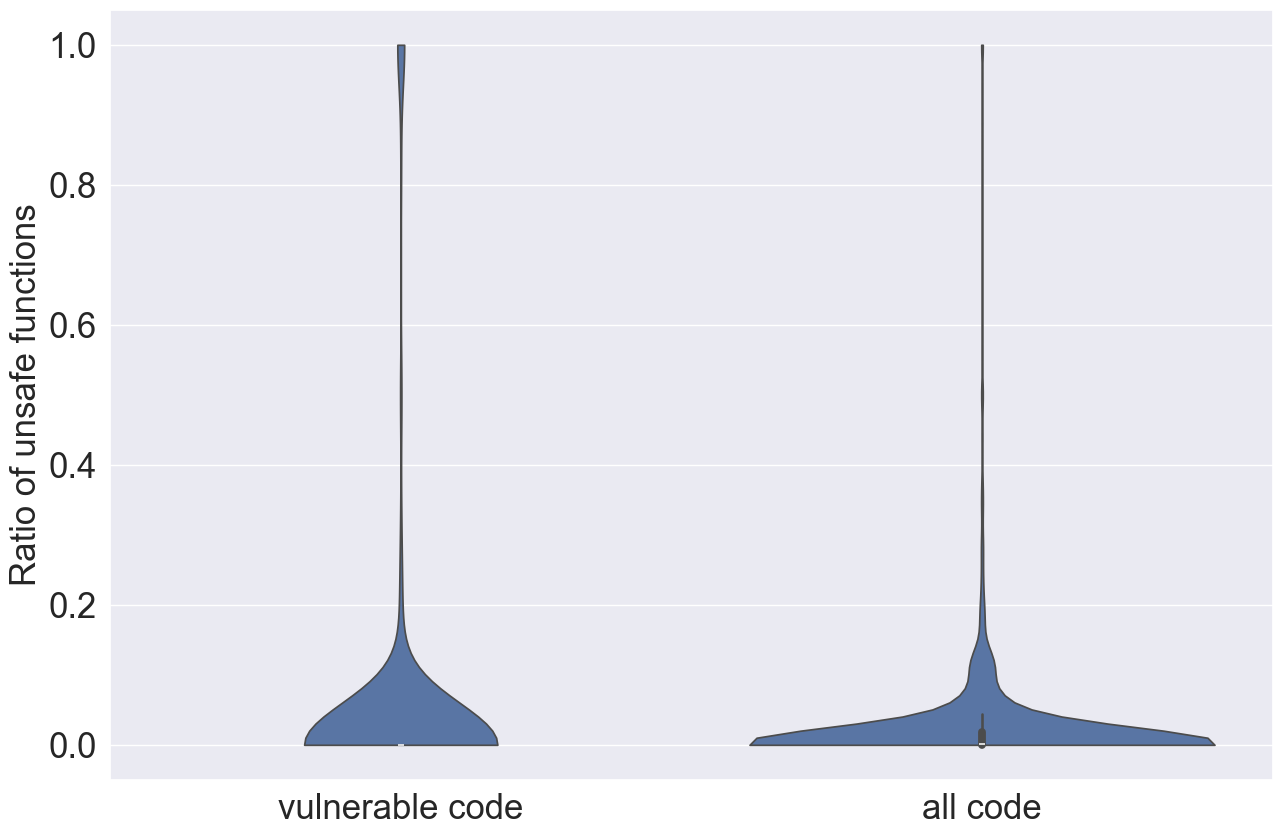

In [ ]:
sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.violinplot(x="type",y="unsafe_func_perc", data=df_data, cut=0)
ax.set(ylabel='Ratio of unsafe functions')
ax.set(xlabel='')
ax.tick_params(labelsize=25)
ax.yaxis.label.set_size(25)
ax.title.set_size(20)
fig = ax.get_figure()
fig.savefig('fig/rq2/func_distribution.png', facecolor='white', dpi=200)